# What ?
Another implementation for IoU metric used in this competition.

# Why ?
I've based my work on these great notebooks [Keras U-Net starter - LB 0.277](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) and [Example Metric Implementation](https://www.kaggle.com/wcukierski/example-metric-implementation). Event tought @keegil provides one implementation of the `mean_iou` metric, the value diverges from the example implementation from @wcukierski. So I start to work on a Keras compatible implementation for the @wcukierski metric.

# Whow ?
Using `tf.py_func` we can use a python function inside Tensorflow environment.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

stage1_sample_submission.csv
stage1_test
stage1_train
stage1_train_labels.csv



In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [3]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:04<00:00, 10.42it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 109.80it/s]

Done!


In [21]:
Y_train[0]

array([[[False],
        [False],
        [False],
        ..., 
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ..., 
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ..., 
        [False],
        [False],
        [False]],

       ..., 
       [[False],
        [False],
        [False],
        ..., 
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ..., 
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ..., 
        [False],
        [False],
        [False]]], dtype=bool)

In [5]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [6]:
from keras import backend as K
K.clear_session()

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x ) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 128, 128, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 128, 8)   224         lambda_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 128, 128, 8)   584         conv2d_1[0][0]                   
___________________________________________________________________________________________

In [7]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=10)

Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - 25s - loss: 0.4248 - my_iou_metric: 0.0933 - val_loss: 0.2127 - val_my_iou_metric: 0.2228
Epoch 2/10
603/603 [==============================] - 24s - loss: 0.1791 - my_iou_metric: 0.2733 - val_loss: 0.3151 - val_my_iou_metric: 0.0427
Epoch 3/10
603/603 [==============================] - 24s - loss: 0.1566 - my_iou_metric: 0.3254 - val_loss: 0.1476 - val_my_iou_metric: 0.3281
Epoch 4/10
603/603 [==============================] - 24s - loss: 0.1504 - my_iou_metric: 0.3569 - val_loss: 0.1883 - val_my_iou_metric: 0.1730
Epoch 5/10
603/603 [==============================] - 24s - loss: 0.1284 - my_iou_metric: 0.3914 - val_loss: 0.1685 - val_my_iou_metric: 0.2227
Epoch 6/10
603/603 [==============================] - 24s - loss: 0.1184 - my_iou_metric: 0.4254 - val_loss: 0.1165 - val_my_iou_metric: 0.4486
Epoch 7/10
603/603 [==============================] - 23s - loss: 0.1113 - my_iou_metric: 0

In [8]:
model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=10)

Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - 22s - loss: 0.0892 - my_iou_metric: 0.4972 - val_loss: 0.1118 - val_my_iou_metric: 0.4629
Epoch 2/10
603/603 [==============================] - 22s - loss: 0.0873 - my_iou_metric: 0.4956 - val_loss: 0.0885 - val_my_iou_metric: 0.4865
Epoch 3/10
603/603 [==============================] - 22s - loss: 0.0851 - my_iou_metric: 0.5030 - val_loss: 0.0782 - val_my_iou_metric: 0.5296
Epoch 4/10
603/603 [==============================] - 22s - loss: 0.0846 - my_iou_metric: 0.5061 - val_loss: 0.0765 - val_my_iou_metric: 0.5310
Epoch 5/10
603/603 [==============================] - 23s - loss: 0.0859 - my_iou_metric: 0.5076 - val_loss: 0.0852 - val_my_iou_metric: 0.5225
Epoch 6/10
603/603 [==============================] - 24s - loss: 0.0818 - my_iou_metric: 0.5159 - val_loss: 0.0985 - val_my_iou_metric: 0.4283
Epoch 7/10
603/603 [==============================] - 23s - loss: 0.0808 - my_iou_metric: 0

In [9]:
# Predict on train, val and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))
    

64/65 [============================>.] - ETA: 0s

In [13]:
preds_train_t

array([[[[0],
         [0],
         [0],
         ..., 
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ..., 
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ..., 
         [0],
         [0],
         [0]],

        ..., 
        [[0],
         [0],
         [0],
         ..., 
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ..., 
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ..., 
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ..., 
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ..., 
         [0],
         [0],
         [1]],

        [[0],
         [0],
         [0],
         ..., 
         [0],
         [0],
         [0]],

        ..., 
        [[0],
         [1],
         [1],
         ..., 
    

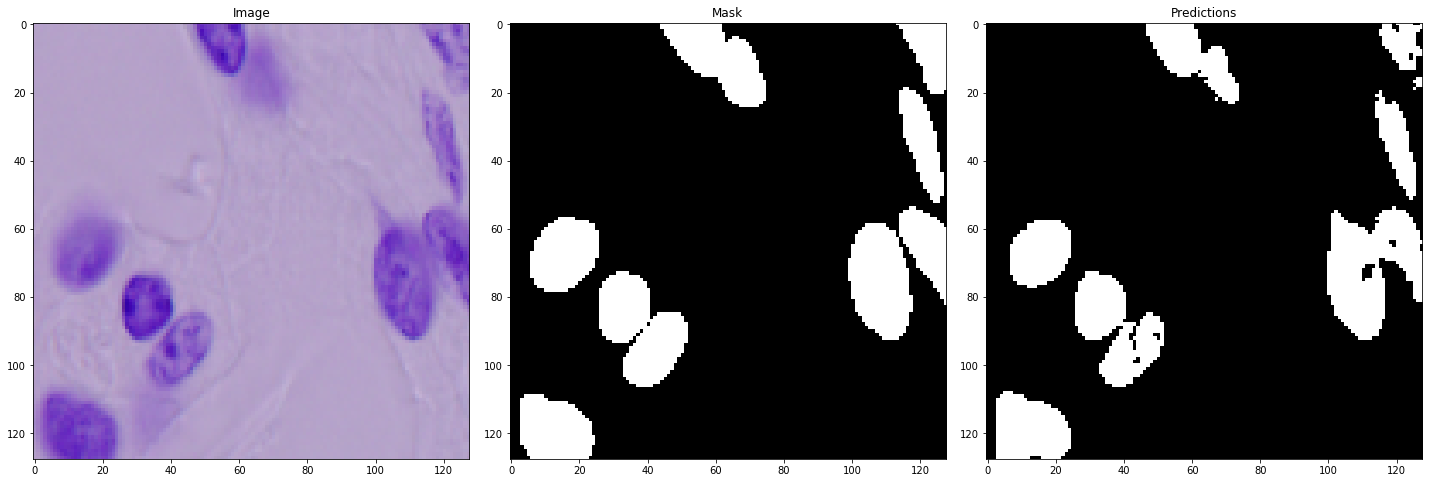

In [17]:
ix = 68
plt.figure(figsize=(20,20))
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

In [16]:
iou_metric(np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix]), print_table=True)

Thresh	TP	FP	FN	Prec.
0.500	9	1	2	0.750
0.550	9	1	2	0.750
0.600	9	1	2	0.750
0.650	9	1	2	0.750
0.700	9	1	2	0.750
0.750	9	1	2	0.750
0.800	9	1	2	0.750
0.850	9	1	2	0.750
0.900	6	4	5	0.400
0.950	1	9	10	0.050
AP	-	-	-	0.645


0.64500000000000002

In [22]:
len(Y_train)

670

In [23]:
np.squeeze(preds_train_t[ix])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)